In [1]:
from data_handlers import StockHistDataHandler,ComputeSuite
from scipy.stats import skew,kurtosis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings("ignore")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xarray as xr
data_handler = StockHistDataHandler()
from utilities.function_utilities import *
from strategy_base import *
from portfolio_base import *

In [37]:
tickers = data_handler(sql = "select ticker from securities ").values.ravel()
ts_range = ["2010-11-15","2021-01-5"]
selected_tickers = tickers
all_data = data_handler.get_data(ticker = selected_tickers, invest_horizen = ts_range)
_ = ComputeSuite.pct_return(all_data.loc[:,:,:])

In [98]:
start_trading = "2018-01-5"
in_sample_data = all_data.loc[:,:,"2016-1-15":"2018-01-5"]
in_sample_data = in_sample_data.loc[:,["adj_close_price","return"],:]
in_sample_data = dropna_ext(in_sample_data)

Raw data dim: (503, 2, 498)
New data dim: (486, 2, 498)
Dropped tickers: ['AMCR' 'BKR' 'CARR' 'CTVA' 'DOW' 'DXC' 'EVRG' 'FOX' 'FOXA' 'FTV' 'IR'
 'LIN' 'LW' 'OTIS' 'UA' 'VNT' 'VTRS']


In [99]:
def _null_handle(sig_gen_func):
    def wrapper(cls, event_data):
        if 0 in event_data.shape:
            return  np.nan*np.ones_like(event_data.columns)
        else:
            return sig_gen_func(cls, event_data)

    return wrapper

class buy_low_strategy_trade_1(strategy):

    def __init__(self, is_test=False):
        super().__init__()
        self.feature = "return"  # todo: handle more features
        self.is_test = is_test

    @_null_handle
    def generate_signal(self, event_data):
        sig = np.zeros(event_data.shape[1])

        previous_return = event_data.values[0]

        todays_return = event_data.values[-1]
        todays_market = np.nanmean(todays_return)

        mkt_condition = (todays_market > 0.00)
        stock_condition = (todays_return < -0.015) & (previous_return < 0.0)
        sig[stock_condition & mkt_condition] = 1
        
#         random_signal = np.random.choice(np.arange(len(sig)),10,replace=False)
#         sig[:]=1
               
        buy_sig_count = len(sig[stock_condition & mkt_condition])

        if sum(sig) <= 2:
            sig[~np.isnan(todays_return)] = 1
            buy_sig_count = 0
        
#         sig[np.sum(event_data.values,axis=0)>-999]=1
        return sig, buy_sig_count


In [100]:
init_holdings = pd.DataFrame(np.zeros(len(in_sample_data.ticker)));init_holdings.index = in_sample_data.ticker; init_holdings.columns = ["share"]
portfolio_1 = portfolio(init_holdings= init_holdings, init_cash = 100, strategy= buy_low_strategy_trade_1(),alloc="equal_dollar")
rolling_apply_ext_xarray(2, in_sample_data, portfolio_1.update)

init


0

In [101]:
market = 100/xarray2df(in_sample_data,"adj_close_price").mean(axis=0)[0]*xarray2df(in_sample_data,"adj_close_price").mean(axis=0)


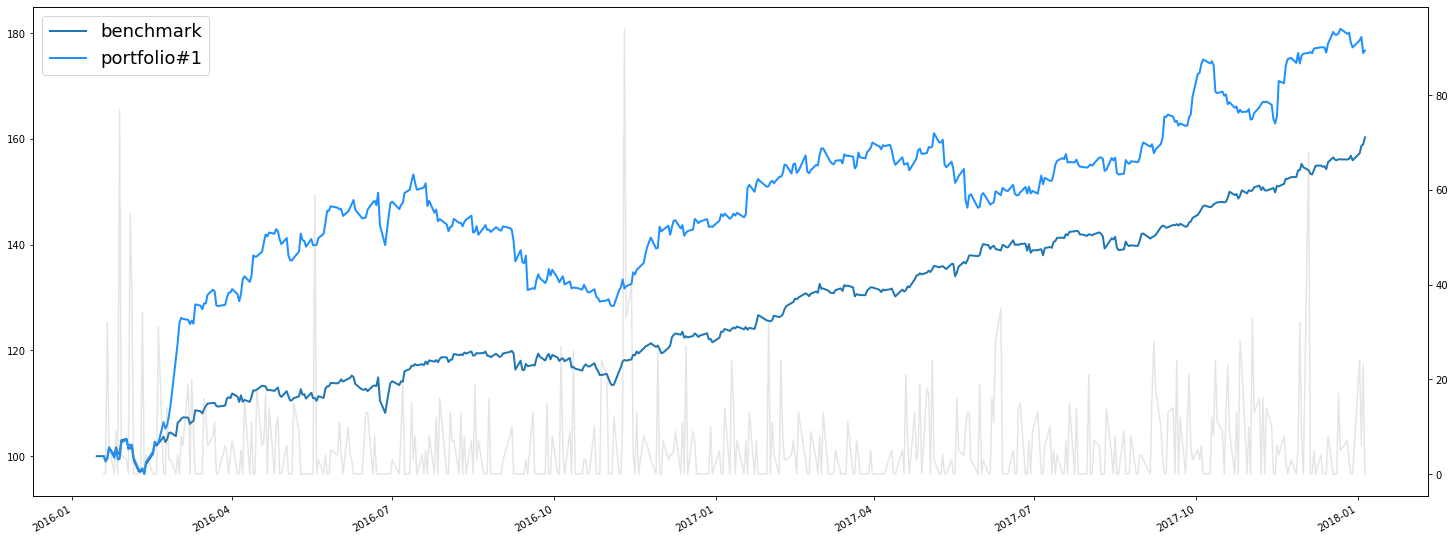

In [102]:
fig,ax = plt.subplots(figsize=(25,10))
market.plot(label="benchmark",lw=2)
portfolio_1.total_asset_hist.plot(ax=ax,c="dodgerblue",label = "portfolio#1",lw=2)
portfolio_1.strategy_hit_point.plot(ax=ax.twinx(),color="gray",alpha=0.2)
ax.legend(fontsize=18)


In [ ]:
z = pd.DataFrame(port)
benchmark = pd.DataFrame(market)
r = z.pct_change(axis=0)
rb = benchmark.pct_change(axis=0)

In [ ]:
np.mean(r[1:])

In [ ]:
np.sqrt(252)*np.mean(r[1:])/np.std(r[1:])

In [ ]:
np.sqrt(252)*np.mean(rb[1:])/np.std(rb[1:])

In [ ]:
  0.861246